In [8]:
import os
import random
import torchbnn as bnn
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
from ray.tune.search.bayesopt import BayesOptSearch
from ray.tune.search.bohb import TuneBOHB
import ray
from ray import tune
from sklearn.datasets import fetch_california_housing
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from sklearn.preprocessing import StandardScaler
import copy
import numpy as np
import pandas as pd
import os
import torch
import tqdm
from torch.utils.data import DataLoader
from torchmetrics.regression import R2Score
import ray.train as train
from ray.air import session
from ray.train.torch import TorchTrainer
from ray.air.config import ScalingConfig
import pyarrow

 C:\Users\omondiagbep\Anaconda3\envs\pytorch\lib\site-packages\torchaudio\backend\utils.py:74: UserWarning:No audio backend is available.


In [9]:
proj_dir = "C:/Projects/SmapProjects/nsdr-bayesian-cnn-mir-pret/"
PREDICT_PROPERTIES=['p_ret']
def get_spectra_data(train_csv, test_csv=None,mineral=False,target_dataframe=None,over_write_csv=False):

    proj_dir = "C:/Projects/SmapProjects/nsdr-bayesian-cnn-mir-pret/"
    SPECTRA_COLUMN_STARTING = "nir."
    ID=['labSampleId']

    # check if this is a target and make the target csv to be the same with the global file used for training
    if isinstance(train_csv, list):
        df_source = pd.concat(map(pd.read_csv, train_csv), ignore_index=True)
        #remove spectra signal which is more than 1
        print("removing out of bound spectra from source")

        #subset only the mineral from the lucas data
        if mineral:
            reflectance_out_of_bound = df_source.loc[df_source[df_source[df_source.columns[pd.Series(df_source.columns).str.startswith(SPECTRA_COLUMN_STARTING)]] > 1].dropna(
            how='all', axis=0).index]
            df_source = df_source.loc[set(df_source.index) - set(reflectance_out_of_bound.index)]

            if 'mineral' in df_source.columns:
                df_source=df_source.loc[df_source['mineral'] == 'mineral']


    if target_dataframe is not None:
        df_target = target_dataframe

    if isinstance(test_csv, list) and target_dataframe is None:
        df_target = pd.concat(map(pd.read_csv, test_csv), ignore_index=True)

        # remove spectra signal which is more than 1
        print("removing out of bound spectra from target")

        if mineral:
            reflectance_out_of_bound = df_target.loc[df_target[df_target[df_target.columns[
                pd.Series(df_target.columns).str.startswith(SPECTRA_COLUMN_STARTING)]] > 1].dropna(
                how='all', axis=0).index]

            df_target = df_target.loc[set(df_target.index) - set(reflectance_out_of_bound.index)]

    #common_cols = list(set.intersection(set(df_target), set(df_source)))
    #print(common_cols)

    common_cols = df_source.columns.intersection(df_target.columns)

    # use this list to perform column selection
    df_target_ = df_target[common_cols]
    df_source_ = df_source[common_cols]


    # extract properties for source and target
    df_source_ = df_source_.filter(regex='^(nir.|p_ret|labSampleId)')
    df_target_ = df_target_.filter(regex='^(nir.|p_ret|labSampleId)')



    # Define the character to remove
    character_to_remove = 'nir.'

    # Remove the character from column names
    df_source_.columns = df_source_.columns.str.replace(character_to_remove, '')
    df_target_.columns = df_target_.columns.str.replace(character_to_remove, '')


    # Extract column names with numbers greater than the threshold
    source_columns_to_drop = [col for col in df_source_.filter(regex='^(nir.)').columns if int(col) > 4000]
    target_columns_to_drop = [col for col in df_target_.filter(regex='^(nir.)').columns if int(col) > 4000]

    # Drop the selected columns from the DataFrame
    df_source_ = df_source_.drop(columns=source_columns_to_drop)
    df_target_ = df_target_.drop(columns=target_columns_to_drop)


    #split train datasest into train and amin_val_loss
    from sklearn.model_selection import train_test_split
    df_source_train, df_source_val= train_test_split(df_source_,  test_size=0.2, random_state=42)



    df_source_train_= df_source_train.drop(columns=[ "p_ret"])
    df_source_val_= df_source_val.drop(columns=["p_ret"])
    df_target__= df_target_.drop(columns=[ "p_ret"])

    df_source_spectral_train = get_spectra(df_source_train_)

    df_source_spectral_val = get_spectra(df_source_val_)
    print(len(df_source_spectral_train))
    print(len(df_source_spectral_val))


    df_target_spectral = get_spectra(df_target__)
    print(len(df_target_spectral))

    #this is use to trim the incoming data when we upload the model to ur api
    if over_write_csv:
        pd.DataFrame(df_source_spectral_train).head(2).to_csv("../Data/ph_source_file.csv", index=False)

    df_source_spectral_train=df_source_spectral_train.to_numpy()
    df_source_spectral_val=df_source_spectral_val.to_numpy()
    df_target_spectral=df_target_spectral.to_numpy()

    print(df_source_spectral_train.shape)

    for i in range(len(PREDICT_PROPERTIES)):
        if PREDICT_PROPERTIES[i] not in df_source_train.columns:
            df_source_train[PREDICT_PROPERTIES[i]] =df_source_train[PREDICT_PROPERTIES[i]]

        if PREDICT_PROPERTIES[i] not in df_source_val.columns:
            df_source_val[PREDICT_PROPERTIES[i]] =df_source_val[PREDICT_PROPERTIES[i]]

        if PREDICT_PROPERTIES[i] not in df_target_.columns and PREDICT_PROPERTIES[i] in  df_target:
            df_target_[PREDICT_PROPERTIES[i]] =df_target[PREDICT_PROPERTIES[i]]

    # remove the 2500 column in the USA/NZ data
    #df_source = df_source.drop([SPECTRA_COLUMN_STARTING, SPECTRA_COLUMN_STARTING + '2500'], axis=1, errors='ignore')
    #df_target = df_target.drop([SPECTRA_COLUMN_STARTING, SPECTRA_COLUMN_STARTING + '2500'], axis=1, errors='ignore')

    return df_source_train, df_source_val,df_target_, df_source_spectral_train,df_source_spectral_val, df_target_spectral


def get_spectra(df):

    filter_col = [col for col in df.columns]

    data = df[filter_col]

    # Ignore first 200 * 0.5 = 100 nm and  pick every 50 * 0.5 = 25 nm
    data=data.iloc[:, 2::10]


    return data

In [10]:
import pandas as pd

#change to match your the path where you have the cal and cal dataset
GLOBAL_CSV=[ "C:/Projects/SmapProjects/SpectraData2023/mir_pret_cali.csv"]
#df_sources, df_targets, df_sources_spectral, df_targets_spectral=get_spectra_data(train_csv=GLOBAL_CSV,target_dataframe=df)

TARGET_CSV=[ "C:/Projects/SmapProjects/SpectraData2023/mir_pret_val.csv"]
df_source_train, df_source_val,df_target, df_source_spectral_train, df_source_spectral_val,df_target_spectral=get_spectra_data(train_csv=GLOBAL_CSV,test_csv=TARGET_CSV,over_write_csv=True)

X_train_raw = df_source_spectral_train#.reshape(df_source_spectral_train.shape[0], df_source_spectral_train.shape[1], 1)
#X_train=np.log(1 / X_train)
y_train = np.array(df_source_train[PREDICT_PROPERTIES].values)

X_val_raw = df_source_spectral_val#.reshape(df_source_spectral_val.shape[0], df_source_spectral_val.shape[1], 1)
y_val= np.array(df_source_val[PREDICT_PROPERTIES].values)


X_test_raw =df_target_spectral#.reshape(df_target_spectral.shape[0], df_target_spectral.shape[1], 1)
y_test =df_target[PREDICT_PROPERTIES].values

removing out of bound spectra from source
removing out of bound spectra from target
2718
680
1132
(2718, 340)


In [11]:
# Standardizing data
scaler = StandardScaler()
scaler.fit(X_train_raw)
scaler.fit(X_val_raw)
X_val = scaler.transform(X_val_raw)
X_train = scaler.transform(X_train_raw)
X_test = scaler.transform(X_test_raw)

In [12]:
# Convert to 2D PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).reshape(-1, 1)
X_val = torch.tensor(X_val, dtype=torch.float32)
y_val = torch.tensor(y_val, dtype=torch.float32).reshape(-1, 1)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32).reshape(-1, 1)



In [13]:
#TEST Model
def evaluate(model,test_x,test,type="mae",sample_size = 100):
    df =evaluate_soil_property(model,test_x,sample_size = sample_size)

    result_total_pret= pd.DataFrame(columns=['upper', 'lower','pred', 'obs'])

    result_total_pret['pred'] = df['pred']

    result_total_pret['lower'] =df['lower']
    result_total_pret['upper'] =df['upper']

    result_total_pret['obs']=test[:,0]

    if type=="mae":
        r2_total_pret =mean_absolute_error(test[:,0],result_total_pret['pred'])
    elif type=="r2":
        r2_total_pret =r2_score(test[:,0],result_total_pret['pred'])
    elif type=="mse":
        r2_total_pret =mean_squared_error(test[:,0],result_total_pret['pred'])
    elif type=="rmse":
        r2_total_pret=np.sqrt(mean_squared_error(test[:,0],result_total_pret['pred']))


    return r2_total_pret


from scipy.stats import norm
def evaluate_soil_property(model,
                         test,
                        sample_size = 100):

     df = pd.DataFrame(columns=['lower','upper','pred'])

     with torch.no_grad():

        model.eval()
        scaler = StandardScaler()
        scaler.fit(test)
        predictions=[]
        test = scaler.transform(test)
        test = torch.tensor(test, dtype=torch.float32)
        for _ in range(sample_size):

            output = model(test)  # Replace 'input_data' with your test input
            predictions.append(output.numpy())

        predictions = torch.tensor(predictions)

        prediction_mean = (torch.mean(predictions, dim=0)).detach().numpy()
        prediction_std = torch.std(predictions, dim=0).detach().numpy()

        # Calculate lower and upper bounds for the prediction interval (e.g., 95% interval)
        lower_bound_ = prediction_mean - 1.645 * prediction_std
        upper_bound_ = prediction_mean + 1.645 * prediction_std


        for i in range(0,len(prediction_mean)):

            #get the first element since we ar predicting just one at a time
            sample_pred = prediction_mean[i][0]

            lower_bound = lower_bound_[i][0]
            upper_bound = upper_bound_[i][0]

            row = {'upper':upper_bound,'lower':abs(lower_bound),'pred':sample_pred}

            df.loc[i] = row
        return df

## 2. Define Model

In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Normal


# class BayesianCNN(nn.Module):
#     def __init__(self,num_feature: int,weight_std=0.001,bias_std=9.5):
#         super(BayesianCNN, self).__init__()
#         #self.fc1 = nn.Linear(340, 256)  # Adjust the input size based on your input size
#         # self.fc1 = nn.Linear(num_feature, 256)
#         # self.fc2 = nn.Linear(256, 128)
#         # self.fc3 = nn.Linear(128, 32)
#         # self.fc5 = nn.Linear(32, 1)  # Output layer for regression
#         self.fc1 = nn.Linear(num_feature, 256)
#         self.fc2 = nn.Linear(256, 128)
#         self.fc3 = nn.Linear(128, 32)
#         self.fc4 = nn.Linear(32, 16)
#         self.fc5 = nn.Linear(16, 1)  # Output layer for regression
#
#         # Define parameters for weight and bias distributions for the linear layer
#         self.weight_mu = nn.Parameter(torch.Tensor(1, 32))
#         self.weight_rho = nn.Parameter(torch.Tensor(1, 32))
#         self.bias_mu = nn.Parameter(torch.Tensor(1))
#         self.bias_rho = nn.Parameter(torch.Tensor(1))
#         self.weight_std=weight_std
#         self.bias_std=bias_std
#
#         # Initialize parameters
#         self.reset_parameters()
#
#     def reset_parameters(self):
#         # Initialize weight means close to zero and standard deviations to be small
#         nn.init.normal_(self.weight_mu, mean=0.0002, std=self.weight_std)
#         nn.init.normal_(self.weight_rho, mean=0.003, std=self.bias_std)
#
#         # Initialize bias means close to zero and standard deviations to be small
#         nn.init.normal_(self.bias_mu, mean=0.0003, std=self.weight_std)
#         nn.init.normal_(self.bias_rho, mean=0.004, std=self.bias_std)
#
#     def forward(self, x):
#         x = x.view(x.size(0), -1)  # Flatten the input
#         x = F.rrelu(self.fc1(x))
#         x = F.rrelu(self.fc2(x))
#         x = F.rrelu(self.fc3(x))
#
#         # Re-parameterization trick for sampling weights
#         weight_epsilon = Normal(0, 1).sample(self.weight_mu.size())
#         weight_sigma = torch.log(1 + torch.exp(self.weight_rho))
#         weight = self.weight_mu + weight_sigma * weight_epsilon
#
#         bias_epsilon = Normal(0, 1).sample(self.bias_mu.size())
#         bias_sigma = torch.log(1 + torch.exp(self.bias_rho))
#         bias = self.bias_mu + bias_sigma * bias_epsilon
#
#         # Enforce non-negativity on weights and biases
#         weight = torch.clamp(weight, min=0)
#         bias = torch.clamp(bias, min=0)
#
#         # Linear layer operation
#         output = F.linear(x, weight, bias)
#         return output


class BayesianCNN(nn.Module):
    def __init__(self, num_feature: int, dims=[256, 512, 128, 32], weight_std=0.001, bias_std=9.5):
        super(BayesianCNN, self).__init__()

        # Define the fully connected layers based on the specified dimensions
        self.fc_layers = nn.ModuleList()
        in_dim = num_feature
        for out_dim in dims:
            self.fc_layers.append(nn.Linear(in_dim, out_dim))
            in_dim = out_dim

        self.fc_out = nn.Linear(in_dim, 1)  # Output layer for pret

        # Update the dimensions of weight_mu and weight_rho to match the output dimension
        self.weight_dim = out_dim
        self.weight_mu = nn.Parameter(torch.Tensor(1, self.weight_dim))
        self.weight_rho = nn.Parameter(torch.Tensor(1, self.weight_dim))

        self.bias_mu = nn.Parameter(torch.Tensor(1))
        self.bias_rho = nn.Parameter(torch.Tensor(1))
        self.weight_std = weight_std
        self.bias_std = bias_std

        # Initialize parameters
        self.reset_parameters()

    def reset_parameters(self):
        # Initialize weight means close to zero and standard deviations to be small
        nn.init.normal_(self.weight_mu, mean=0.0002, std=self.weight_std)
        nn.init.normal_(self.weight_rho, mean=0.003, std=self.bias_std)

        # Initialize bias means close to zero and standard deviations to be small
        nn.init.normal_(self.bias_mu, mean=0.0003, std=self.weight_std)
        nn.init.normal_(self.bias_rho, mean=0.004, std=self.bias_std)

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten the input

        # Pass through fully connected layers with specified dimensions
        for fc_layer in self.fc_layers:
            x = F.rrelu(fc_layer(x))

        # Re-parameterization trick for sampling weights
        weight_epsilon = Normal(0, 1).sample(self.weight_mu.size())
        weight_sigma = torch.log(1 + torch.exp(self.weight_rho))
        weight = self.weight_mu + weight_sigma * weight_epsilon

        bias_epsilon = Normal(0, 1).sample(self.bias_mu.size())
        bias_sigma = torch.log(1 + torch.exp(self.bias_rho))
        bias = self.bias_mu + bias_sigma * bias_epsilon

        # Enforce non-negativity on weights and biases
        weight = torch.clamp(weight, min=0)
        bias = torch.clamp(bias, min=0)

        # Final linear layer operation
        output = F.linear(x, weight, bias)
        return output

In [15]:
train = torch.utils.data.TensorDataset(X_train,y_train)
train_dataloader = DataLoader(train, batch_size=16)

val= torch.utils.data.TensorDataset(X_val,y_val)
val_dataloader = DataLoader(val, batch_size=16)

test= torch.utils.data.TensorDataset(X_test,y_test)
test_dataloader = DataLoader(test, batch_size=16)

In [16]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

#Manually compute the L1 loss over all model parameters:
def l1_penalty(model):
    l1_loss = 0.0
    for param in model.parameters():
        l1_loss += torch.abs(param).sum()
    return l1_loss

def train_epoch(train,val,model,loss_fn,optimizer,batch_size,n_epochs):

    train_dataloader = DataLoader(train, batch_size=batch_size)
    model.train()
    for epoch in range(n_epochs):
        for inputs, targets in train_dataloader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_fn(outputs, targets)
            loss.backward()
            optimizer.step()

        # Print the training loss for this epoch
        print(f"Epoch [{epoch+1}/{n_epochs}] Loss: {loss.item():.5f}")
        #evaluate accuracy at end of each epoch
        test_epoch(val,model, loss_fn ,optimizer,batch_size,n_epochs)

def test_epoch(val,model,loss_fn,optimizer,batch_size,n_epochs):
    val_dataloader = DataLoader(val, batch_size=batch_size)
    val_loss=0
    model.eval()
    for inputs, targets in val_dataloader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_fn(outputs, targets)
            val_loss += loss.item()
            loss.backward()
            optimizer.step()

        # Print the training loss for this epoch
    avg_val_loss = val_loss / len(inputs)
    print(f"Epoch [{n_epochs+1}/{n_epochs}] Val Loss: {loss.item():.5f}")


    return avg_val_loss


def get_metrics(test,y_test,model):
    loss_fn = nn.MSELoss()

    model.eval()

    y_pred = model(test)
    mse = loss_fn(y_pred, y_test)
    mse = float(mse)
    rmse= np.sqrt(mse)

    test_result= evaluate_soil_property(model,test)
    test_result["obs"] = y_test
    pcip = calculate_pcip(test_result["obs"], test_result['lower'], test_result['upper'])
    r2score = R2Score()
    r2= r2score(y_pred, y_test).item()

    r2_pent =r2*100
    #Balancing Trade-offs between r2 and pcip:
    score_avg = (pcip +  r2_pent)/2
    print(f'MSE: {mse:.4f},R2: {r2:.4f},RMSE: {rmse:.4f}, PCIP: {pcip:.2f},score_avg:{score_avg:.4f}')
    return [mse,r2,rmse,pcip]

def calculate_pcip(y_true, lower_bounds, upper_bounds):
    num_samples = len(y_true)
    num_covering_intervals = np.sum((lower_bounds <= y_true) & (y_true <= upper_bounds))
    pcip = (num_covering_intervals / num_samples) * 100
    return pcip

Using cpu device


## 2. Hyperparamter tuning to find best Architecture

In [26]:
from ray.tune.search.optuna import OptunaSearch
import torch
import torch.optim as optim
import ray
from ray.air import session, Checkpoint
from ray.tune.schedulers import PopulationBasedTraining, HyperBandForBOHB
from ray.tune.schedulers import AsyncHyperBandScheduler
from enum import Enum
loss_fn = nn.MSELoss()


class Optimiser(str, Enum):
    Adams = "Adams"
    SGD ="SGD"
    Adadelta = "Adadelta"
    Adagrad = "Adagrad"
    Adamax = "Adamax"
    Nadam = "Nadam"
    Ftrl = "Ftrl"
    RMSprop="RMSprop"
    LBFGS ="LBFGS"
    #LBFGS ="LBFGS"
    def __str__(self):
        return self.value

 # set your desired L1 regularization strength
def objective(config):  # ①

    #dataset
    train = torch.utils.data.TensorDataset(X_train,y_train)

    val= torch.utils.data.TensorDataset(X_val,y_val)


    #dim = random.sample(output_dims, config["n_layers"])

    criterion=nn.MSELoss()



    model = BayesianCNN(num_feature=X_train.shape[1],dims=config["dims"],
                       weight_std=config["weight_std"],
                      bias_std=config["bias_std"]).to("cpu")   # Create a PyTorch conv net

    if config["optimiser"] == Optimiser.RMSprop:
        optimizer = torch.optim.RMSprop(model.parameters(), momentum=config["opt_momentum"], lr=config["lr"])
    elif config["optimiser"] == Optimiser.LBFGS:
        optimizer = torch.optim.LBFGS(model.parameters(),  lr=config["lr"])
    elif config["optimiser"] == Optimiser.Adams:
        optimizer = torch.optim.Adam(model.parameters(),  lr=config["lr"])
    elif config["optimiser"] == Optimiser.SGD:
        optimizer = torch.optim.SGD(model.parameters(),  lr=config["lr"],momentum=config["opt_momentum"])
    elif config["optimiser"] == Optimiser.Nadam:
        optimizer = torch.optim.NAdam(model.parameters(),  lr=config["lr"],momentum_decay=config["opt_momentum"])

    checkpoint = session.get_checkpoint()

    if checkpoint:
        checkpoint_state = checkpoint.to_dict()
        with checkpoint.as_directory() as dir_path:
            print("test")
            model_state, optimizer_state = torch.load(os.path.join(dir_path, "checkpoint.pt"))

            # Load optimizer state (needed since we're using momentum),
            # then set the `lr` and `momentum` according to the config.
            optimizer.load_state_dict(optimizer_state)
            model.load_state_dict(model_state)
        for param_group in optimizer.param_groups:
            if "lr" in config:
                param_group["lr"] = config["lr"]
            if "opt_momentum" in config:
                param_group["opt_momentum"] = config["opt_momentum"]

    while True:

        train_epoch(train,val,model, criterion ,optimizer,config["batch_size"],config["epochs"])  # Train the model

        os.makedirs("model", exist_ok=True)
        torch.save(
            (model.state_dict(), optimizer.state_dict()), "model/checkpoint.pt")


        mse,r2,rmse,pcip = get_metrics(X_test,y_test,model)  # Compute test accuracy
        #optimise with pcip and r2
        r2_pent =r2*100
        score_avg = (pcip+r2_pent)/2
        checkpoint = Checkpoint.from_directory("model")

        session.report({"done": pcip > 99 and rmse < 0.25,"mse": mse, "r2": r2,"rmse": rmse, "pcip": pcip,"score_avg":score_avg},checkpoint=checkpoint)  # Report to Tune

##### RUN  ##############
import ray
from ray.tune.search.hyperopt import HyperOptSearch
from ray.tune.search import ConcurrencyLimiter
from ray.tune.schedulers import AsyncHyperBandScheduler
from ray.tune.schedulers.pb2 import PB2
from ray.tune import tune
import random

ray.shutdown()
# Your original list of dimensions
original_dims = [512, 256,  128, 64, 32,  16,  8, 512,256,128,64,28]
# List of optimizer names
optimizer_names = ["Adams", "SGD","Nadam"]
optimizer_names = ["Adams", "Nadam"]
ray.init(num_cpus=4, num_gpus=0,_temp_dir="/ray") # assign the total # of cpus and gpus, make sure you have ray.init in the beginning and ray.shutdown at the end
sched = AsyncHyperBandScheduler(  time_attr="training_iteration",
    reduction_factor=2,
    metric='rmse',
    mode='min')  # set a scheduler

perturbation_interval = 10
#use population based training
scheduler =PopulationBasedTraining(
       time_attr="training_iteration",
    perturbation_interval=perturbation_interval,
    metric="rmse",
    mode="min",
    quantile_fraction=0.25,  # copy bottom % with top %
    #hyperparam_mutation - for pbt
    hyperparam_mutations={
        # distribution for resampling
        "lr": [0.0001, 0.1],
        "momentum": [0.009,0.01],
        "opt_momentum": [0.009,0.01],
    }
)
algo =OptunaSearch(metric=["rmse","pcip"], mode=["min","max"])# HyperOptSearch() # if you want to use the Bayesian optimization, import BayesOptSearch instead
algo = ConcurrencyLimiter(algo, max_concurrent=12)
scheduler = HyperBandForBOHB(
    time_attr="training_iteration",
    max_t=30,
    #metric="rmse",
    #mode='min',
    reduction_factor=0.25,
    stop_last_trials=False,
)
scheduler = PB2(
    time_attr="training_iteration",
    perturbation_interval=perturbation_interval,
    metric="score_avg",
    mode="max",
    quantile_fraction=0.4,  # copy bottom % with top %
    #hyperparam_mutation - for pbt
    hyperparam_bounds={
        # distribution for resampling
        "lr": [0.00001, 0.1],
        "momentum": [0.009,0.01],
        "opt_momentum": [0.009,0.01],
    },
)
analysis = tune.run(
        objective,   # the core training/testing of your model
        #storage_path=os.getcwd(), # for saving the log files
        name="pbt_prent2", # name for the result directory
        #resume="REMOTE",
        #metric="rmse",
        #resume="PROMPT",  # use only if resuming trial after failed experiement
        #mode='min',
        #search_alg=algo,
        scheduler=scheduler,
        stop={
                "training_iteration": 20,
                "done": True,
                "rmse": 0.05,
        },
        resources_per_trial={
                "cpu": 1,
                "gpu": 0
         },
        num_samples=30, # 50 trials
        progress_reporter=ray.tune.JupyterNotebookReporter(metric="score_avg",overwrite=True,max_report_frequency=7),
        config={

               "lr": ray.tune.loguniform(0.00001, 0.1),
                "l1_coef": ray.tune.loguniform(0.00001, 0.3),
                "dims": ray.tune.sample_from(lambda spec: random.choices(original_dims,k=random.randint(2, 7))),
                  #"pred_interval_constant":ray.tune.loguniform(0.28, 12.05),
                 "momentum": ray.tune.loguniform(0.009,0.01),
                 "weight_std": ray.tune.loguniform(0.0001,10.02),
                 "bias_std": ray.tune.loguniform(0.01, 17.7),
                 "batch_size": ray.tune.randint(2,128),
                 "epochs":ray.tune.randint(2,1000),
                "optimiser": ray.tune.sample_from(lambda spec: random.choice(optimizer_names)),
                 "checkpoint_interval": perturbation_interval
        })


2023-09-30 23:46:33,575	INFO tune.py:657 -- [output] This uses the legacy output and progress reporter, as Jupyter notebooks are not supported by the new engine, yet. For more information, please see https://github.com/ray-project/ray/issues/36949
2023-09-30 23:46:33,885	WARNING callback.py:144 -- The TensorboardX logger cannot be instantiated because either TensorboardX or one of it's dependencies is not installed. Please make sure you have the latest version of TensorboardX installed: `pip install -U tensorboardx`
2023-09-30 23:46:42,454	WARNING worker.py:2037 -- Warning: The actor ImplicitFunc is very large (11 MiB). Check that its definition is not implicitly capturing a large array or other object in scope. Tip: use ray.put() to put large objects in the Ray object store.
(pid=34312) C:\Users\omondiagbep\Anaconda3\envs\pytorch\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
(pid=34312) C:\Users\omondiagbep\Anaconda3\envs\pytorch\lib\

(objective pid=21680) Epoch [1/739] Loss: 142.59097
(objective pid=21680) Epoch [740/739] Val Loss: 100.96497
(objective pid=18756) Epoch [2/796] Loss: 1361.87280 [repeated 3x across cluster]
(objective pid=18756) Epoch [797/796] Val Loss: 2116.19287 [repeated 3x across cluster]
(objective pid=21680) Epoch [4/739] Loss: 110.71931 [repeated 3x across cluster]
(objective pid=38712) Epoch [779/778] Val Loss: 114.33727 [repeated 5x across cluster]
(objective pid=18756) Epoch [6/796] Loss: 1112.20728 [repeated 5x across cluster]
(objective pid=21680) Epoch [740/739] Val Loss: 72.50934 [repeated 4x across cluster]
(objective pid=21680) Epoch [8/739] Loss: 110.96784 [repeated 6x across cluster]
(objective pid=18756) Epoch [797/796] Val Loss: 1803.86816 [repeated 4x across cluster]
(objective pid=18756) Epoch [11/796] Loss: 755.43518 [repeated 6x across cluster]
(objective pid=18756) Epoch [797/796] Val Loss: 1522.15454 [repeated 5x across cluster]
(objective pid=18756) Epoch [13/796] Loss: 88

Trial name,mse,pcip,r2,rmse,score_avg,should_checkpoint
objective_9f55e_00003,50.3779,25.265,0.928226,7.09774,59.0438,True


In [35]:
best_trials = analysis.get_best_trial("pcip", "max", "all")
print(f"Best trial config: {best_trials.config}")
print(f"Best trial final validation mse: {best_trials.last_result['mse']}")
print(f"Best trial final validation r2: {best_trials.last_result['r2']}")
print(f"Best trial final validation rmse: {best_trials.last_result['rmse']}")
print(f"Best trial final validation pcip: {best_trials.last_result['pcip']}")
#print(f"Best trial final validation score_avg: {best_trials.last_result['optimal_dim']}")
#print(f"Best trial final validation l1_coef: {best_trial.last_result['l1_coef']}")
best_checkpoints = best_trials.checkpoint.to_air_checkpoint()


Best trial config: {'lr': 5.5570050367622994e-05, 'l1_coef': 0.001109775915145248, 'dims': [32, 32], 'momentum': 0.009311237799370906, 'weight_std': 0.01115938637456951, 'bias_std': 0.14172243920558592, 'batch_size': 115, 'epochs': 789, 'optimiser': 'Adams', 'checkpoint_interval': 10, 'opt_momentum': 0.009215635669222707}
Best trial final validation mse: 87.83853149414062
Best trial final validation r2: 0.874854564666748
Best trial final validation rmse: 9.37222126788205
Best trial final validation pcip: 85.24734982332156


In [36]:
gpus_per_trial = 2
best_trained_model=BayesianCNN(num_feature=X_train.shape[1],dims=best_trials.config["dims"],
                           weight_std=best_trials.config["weight_std"],
                          bias_std=best_trials.config["bias_std"])

device = "cpu"
if torch.cuda.is_available():
    device = "cuda:0"
    if gpus_per_trial > 1:
        best_trained_model = nn.DataParallel(best_trained_model)
best_trained_model.to(device)
with best_checkpoints.as_directory() as dir_path:
    print(dir_path)
    model_state, optimizer_state = torch.load(os.path.join(dir_path, "checkpoint.pt"))
    best_trained_model.load_state_dict(model_state)
best_checkpoint_data = best_checkpoints.to_dict()




C:\Users\omondiagbep\ray_results\pbt_prent2\objective_9f55e_00028_28_batch_size=115,bias_std=0.1417,epochs=789,l1_coef=0.0011,lr=0.0001,momentum=0.0093,weight_std=0.0112_2023-10-01_03-37-36\checkpoint_000000


In [27]:



def train_func(model,optimizer_=None,n_epochs = 1000,batch_size = 16,lr=0.0001):
    loss_fn = nn.MSELoss()  # mean square error

    if optimizer_ is None:
        optimizer = torch.optim.Adam(model.parameters(),  lr=lr)
    if optimizer_ == Optimiser.RMSprop:
        optimizer = torch.optim.RMSprop(model.parameters(), momentum=best_trials.config["opt_momentum"], lr=best_trials.config["lr"])
    elif optimizer_ == Optimiser.LBFGS:
        optimizer = torch.optim.LBFGS(model.parameters(),  lr=best_trials.config["lr"])
    elif optimizer_ == Optimiser.Adams:
        optimizer = torch.optim.Adam(model.parameters(),  lr=best_trials.config["lr"])
    elif optimizer_ == Optimiser.SGD:
        optimizer = torch.optim.SGD(model.parameters(),  lr=best_trials.config["lr"],momentum=best_trials.config["opt_momentum"])
    elif optimizer_ == Optimiser.Nadam:
        optimizer = torch.optim.NAdam(model.parameters(),  lr=best_trials.config["lr"],momentum_decay=best_trials.config["opt_momentum"])



    # Hold the best model
    best_mse = np.inf # init to infinity

    history = []
    epochs_no_improve = 0

    early_stop=False
    n_epochs_stop = 40
    min_val_loss=float('inf')
    best_r2 = 0.0000
    best_pcip = 0.0000
    criterion=nn.MSELoss()

    train = torch.utils.data.TensorDataset(X_train,y_train)
    val = torch.utils.data.TensorDataset(X_val,y_val)
    train_dataloader = DataLoader(train, batch_size=batch_size)
    val_dataloader = DataLoader(val, batch_size=batch_size)
    for epoch in range(n_epochs):
        model.train()
        train_loss =0
        val_loss=0

        for inputs, targets in train_dataloader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

        # Print the training loss for this epoch
        print(f"Epoch [{epoch+1}/{n_epochs}] Loss: {loss.item():.5f}")

        for inputs, targets in val_dataloader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            val_loss += loss.item()
            loss.backward()
            optimizer.step()

        # Print the training loss for this epoch
        avg_val_loss = val_loss / len(inputs)
        print(f"Epoch [{epoch+1}/{n_epochs}] Val Loss: {loss.item():.5f}")

        #at the start
        if avg_val_loss < min_val_loss:
            epochs_no_improve = 0
            min_val_loss = avg_val_loss
            print("restarting counter")
            print(epochs_no_improve)
        else:
            epochs_no_improve += 1
            print("increasing counter")
            print(epochs_no_improve)

        if epochs_no_improve == n_epochs_stop:
            print('Early stopping!')
            early_stop = True
            break
        # evaluate accuracy at end of each epoch
        model.eval()
        mse,r2,rmse,pcip = get_metrics(X_test,y_test,model)
        print(f'r2: {r2:.4f}')
        print(f'pcip: {pcip:.4f}')
        y_pred = model(X_test)

        mse = loss_fn(y_pred, y_test)
        mse = float(mse)
        rmse= np.sqrt(mse)
        print(f'RMSE: {rmse:.4f}')
        history.append(rmse)
        if rmse < best_mse:
            best_mse = rmse

        if r2 > best_r2 :
            best_r2 = r2
            print("save rmse state")
            modelrmse_state_dict = model.state_dict()
        if pcip > best_pcip :
            best_pcip = pcip
            print("save pcip state")
            modelpcip_state_dict = model.state_dict()

        if early_stop:
            print('Training stopped early.')


        print(f'Best RMSE so far: {best_mse:.4f}')
        print(f'Best r2 so far: {best_r2:.4f}')

        print(f'Best pcip so far: {best_pcip:.4f}')


    modelrmse_state_dict.update(modelpcip_state_dict)

    # Load the updated state_dict back into model
    model.load_state_dict(modelrmse_state_dict)
    print("RMSE: %.2f" % best_mse)
    plt.plot(history)
    plt.show()
    return model,history,best_mse

## Best architecture found

In [241]:
#fine tune if needed - not use

model = BayesianCNN(num_feature=X_train.shape[1],dims=best_trials.config["dims"],
                       weight_std=best_trials.config["weight_std"],
                      bias_std=best_trials.config["bias_std"]).to("cpu")

Epoch [1/28] Loss: 927.94470
Epoch [1/28] Val Loss: 1615.51379
restarting counter
0
MSE: 1422.6927,R2: -1.0269,RMSE: 37.7186, PCIP: 10.95,score_avg:-45.8700
r2: -1.0269
pcip: 10.9541
RMSE: 36.4444
save pcip state
Best RMSE so far: 36.4444
Best r2 so far: 0.0000
Best pcip so far: 10.9541
Epoch [2/28] Loss: 581.14331
Epoch [2/28] Val Loss: 1071.62500
restarting counter
0
MSE: 452.5453,R2: 0.3552,RMSE: 21.2731, PCIP: 37.54,score_avg:36.5345
r2: 0.3552
pcip: 37.5442
RMSE: 22.0058
save rmse state
save pcip state
Best RMSE so far: 22.0058
Best r2 so far: 0.3552
Best pcip so far: 37.5442
Epoch [3/28] Loss: 288.75668
Epoch [3/28] Val Loss: 439.67654
restarting counter
0
MSE: 197.7472,R2: 0.7183,RMSE: 14.0623, PCIP: 70.32,score_avg:71.0723
r2: 0.7183
pcip: 70.3180
RMSE: 22.4282
save rmse state
save pcip state
Best RMSE so far: 22.0058
Best r2 so far: 0.7183
Best pcip so far: 70.3180
Epoch [4/28] Loss: 198.82574
Epoch [4/28] Val Loss: 86.66983
restarting counter
0
MSE: 177.3616,R2: 0.7473,RMSE: 

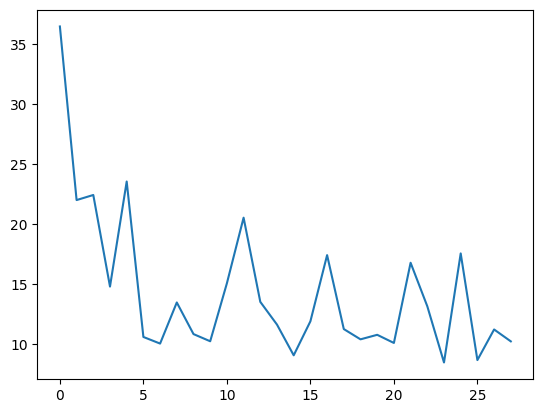

In [242]:
#model,history,best_mse =train_func(model,n_epochs=best_trials.config["n_epochs"],batch_size=best_trials.config["batch_size"], lr=best_trials.config["lr"])

In [93]:
#save model
best_model_name = f'mir_pret_model-1.0.1.pt'
torch.save(best_trained_model.state_dict(),os.path.join("../../model-store/",best_model_name))


In [67]:
best_model_name = f'mir_pret_model-1.0.0.pt'
final_model=torch.load(os.path.join("../../model-store/",best_model_name))

In [91]:
best_trials.config["dims"]

[32, 32]

In [71]:
## Testing
final_model.eval()
with torch.no_grad():
    # Test out inference with 5 samples
    for i in range(5):
        X_sample = X_test_raw[i: i+1]
        X_sample = scaler.transform(X_sample)
        X_sample = torch.tensor(X_sample, dtype=torch.float32)
        y_pred = final_model(X_sample)

        print(f"{y_pred.numpy()} (expected {y_test[i].numpy()})")


[[32.612785]] (expected [32.])
[[6.4317684]] (expected [10.])
[[49.95325]] (expected [42.])
[[4.193227]] (expected [7.])
[[49.247314]] (expected [60.])


In [88]:
## Validation on Test dataset
test_result= evaluate_soil_property(best_trained_model,X_test_raw,sample_size=500)
test_result["obs"] = y_test
test_result['type'] ='Validation'
test_result['variable'] ='P retention'
test_result

,lower,upper,pred,obs,type,variable
0,17.480986,36.883858,27.182423,32.0,Validation,P retention
1,5.604764,12.690436,9.147600,10.0,Validation,P retention
2,28.884142,60.900970,44.892555,42.0,Validation,P retention
3,2.705796,7.336060,5.020928,7.0,Validation,P retention
4,38.009529,79.905052,58.957291,60.0,Validation,P retention
...,...,...,...,...,...,...
1127,51.780827,108.198776,79.989799,87.0,Validation,P retention
1128,17.154190,36.479149,26.816669,23.0,Validation,P retention
1129,60.175907,125.900894,93.038399,94.0,Validation,P retention
1130,42.624359,88.669815,65.647087,78.0,Validation,P retention


In [56]:
##Testing on Training dataset
train_result= evaluate_soil_property(best_trained_model,X_train_raw,sample_size=1000)
train_result["obs"] = y_train
train_result['type'] =' Calibration'
train_result['variable'] ='P retention'
train_result

,lower,upper,pred,obs,type,variable
0,17.127718,35.029022,26.078369,20.0,Calibration,P retention
1,8.261868,18.245346,13.253607,11.0,Calibration,P retention
2,61.581116,122.139526,91.860321,97.0,Calibration,P retention
3,18.226257,37.004856,27.615557,29.0,Calibration,P retention
4,42.938011,85.772438,64.355225,66.0,Calibration,P retention
...,...,...,...,...,...,...
2713,12.369984,24.594173,18.482079,19.0,Calibration,P retention
2714,11.938437,23.567213,17.752825,21.0,Calibration,P retention
2715,13.715346,27.508167,20.611757,20.0,Calibration,P retention
2716,50.748528,101.651634,76.200081,93.0,Calibration,P retention


In [60]:
final_df=pd.merge(train_result,test_result,how="outer")

In [61]:
final_df.to_csv("../../CNN/cnn_pret.csv")
final_df

,lower,upper,pred,obs,type,variable
0,17.127718,35.029022,26.078369,20.0,Calibration,P retention
1,8.261868,18.245346,13.253607,11.0,Calibration,P retention
2,61.581116,122.139526,91.860321,97.0,Calibration,P retention
3,18.226257,37.004856,27.615557,29.0,Calibration,P retention
4,42.938011,85.772438,64.355225,66.0,Calibration,P retention
...,...,...,...,...,...,...
3845,47.764103,114.337845,81.050972,87.0,Validation,P retention
3846,15.595829,38.745304,27.170567,23.0,Validation,P retention
3847,55.361198,133.231354,94.296280,94.0,Validation,P retention
3848,39.502590,93.904877,66.703735,78.0,Validation,P retention


In [89]:
import numpy as np

def calculate_pcip(y_true, lower_bounds, upper_bounds):
    num_samples = len(y_true)
    num_covering_intervals = np.sum((lower_bounds <= y_true) & (y_true <= upper_bounds))
    pcip = (num_covering_intervals / num_samples) * 100
    return pcip

pcip = calculate_pcip(test_result['obs'], test_result['lower'], test_result['upper'])
print(f"Prediction Interval Coverage Probability (PCIP): {pcip:.2f}%")


Prediction Interval Coverage Probability (PCIP): 88.43%


In [201]:
#mean predition interval width
def calculate_mpiw(lower_bounds, upper_bounds):
    num_samples = len(lower_bounds)
    num_covering_intervals = np.sum(upper_bounds -lower_bounds)
    mpiw = (num_covering_intervals / num_samples)
    return mpiw

mpiw = calculate_mpiw(test_result['lower'], test_result['upper'])
print(f"Mean Prediction Interval Width (mpiw): {mpiw:.2f}")


Mean Prediction Interval Width (mpiw): 5.60


In [21]:
evaluate(best_trained_model,X_train_raw,y_train,type="r2")

0.9639770015709561

In [55]:
evaluate(best_trained_model,X_test_raw,y_test,type="r2")

0.9090862945955508

In [43]:
evaluate(best_trained_model,X_test_raw,y_test,type="rmse")


8.355406

In [23]:
evaluate(best_trained_model,X_train_raw,y_train,type="rmse")


5.069451


############ Experiment  with IVR and MCMC - Dont Run #################################

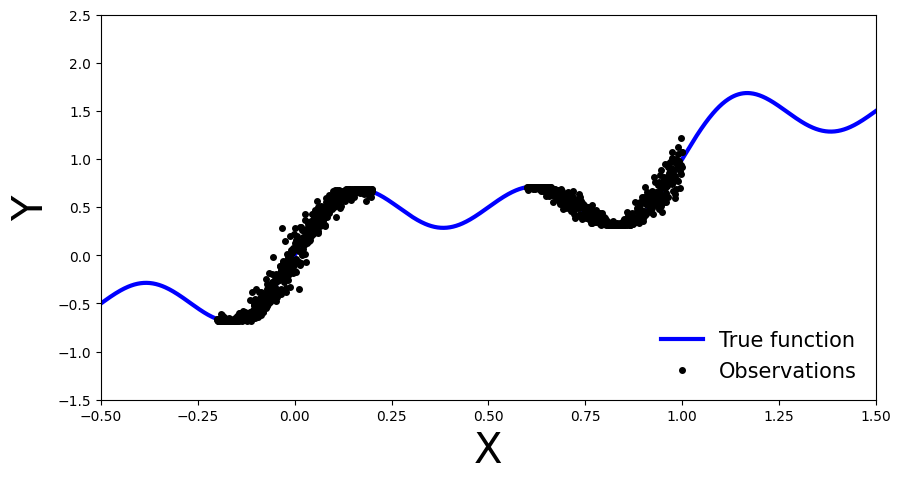

In [19]:
import torch
import numpy as np
import matplotlib.pyplot as plt

# Set random seed for reproducibility
np.random.seed(42)

# Generate data
x_obs = np.hstack([np.linspace(-0.2, 0.2, 500), np.linspace(0.6, 1, 500)])
noise = 0.02 * np.random.randn(x_obs.shape[0])
y_obs = x_obs + 0.3 * np.sin(2 * np.pi * (x_obs + noise)) + 0.3 * np.sin(4 * np.pi * (x_obs + noise)) + noise

x_true = np.linspace(-0.5, 1.5, 1000)
y_true = x_true + 0.3 * np.sin(2 * np.pi * x_true) + 0.3 * np.sin(4 * np.pi * x_true)

# Set plot limits and labels
xlims = [-0.5, 1.5]
ylims = [-1.5, 2.5]

# Create plot
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(x_true, y_true, 'b-', linewidth=3, label="True function")
ax.plot(x_obs, y_obs, 'ko', markersize=4, label="Observations")
ax.set_xlim(xlims)
ax.set_ylim(ylims)
ax.set_xlabel("X", fontsize=30)
ax.set_ylabel("Y", fontsize=30)
ax.legend(loc=4, fontsize=15, frameon=False)

plt.show()

In [23]:
x_true.shape

(1000,)

In [18]:
import pyro
import pyro.distributions as dist
from pyro.nn import PyroModule, PyroSample
import torch.nn as nn

In [185]:
class MyFirstBNN(PyroModule):
    def __init__(self, in_dim=22, out_dim=1, hid_dim=5, prior_scale=10.):
        super().__init__()

        self.activation = nn.Tanh()  # or nn.ReLU()
        self.layer1 = PyroModule[nn.Linear](in_dim, hid_dim)  # Input to hidden layer
        self.layer2 = PyroModule[nn.Linear](hid_dim, out_dim)  # Hidden to output layer

        # Set layer parameters as random variables
        self.layer1.weight = PyroSample(dist.Normal(0., prior_scale).expand([hid_dim, in_dim]).to_event(2))
        self.layer1.bias = PyroSample(dist.Normal(0., prior_scale).expand([hid_dim]).to_event(1))
        self.layer2.weight = PyroSample(dist.Normal(0., prior_scale).expand([out_dim, hid_dim]).to_event(2))
        self.layer2.bias = PyroSample(dist.Normal(0., prior_scale).expand([out_dim]).to_event(1))

    def forward(self, x, y=None):
        #x = x.reshape(-1, 1)
        x = self.activation(self.layer1(x))
        mu = self.layer2(x).squeeze()
        sigma = pyro.sample("sigma", dist.Gamma(.5, 1))  # Infer the response noise

        # Sampling model
        with pyro.plate("data", x.shape[0]):
            obs = pyro.sample("obs", dist.Normal(mu, sigma * sigma), obs=y)
        return mu



def plot_predictions(preds):
    y_pred = preds['obs'].T.detach().numpy().mean(axis=1)
    y_std = preds['obs'].T.detach().numpy().std(axis=1)

    fig, ax = plt.subplots(figsize=(10, 5))
    xlims = [-0.5, 1.5]
    ylims = [-1.5, 2.5]
    plt.xlim(xlims)
    plt.ylim(ylims)
    plt.xlabel("X", fontsize=30)
    plt.ylabel("Y", fontsize=30)

    ax.plot(x_true, y_true, 'b-', linewidth=3, label="true function")
    ax.plot(x_obs, y_obs, 'ko', markersize=4, label="observations")
    ax.plot(x_obs, y_obs, 'ko', markersize=3)
    ax.plot(x_test, y_pred, '-', linewidth=3, color="#408765", label="predictive mean")
    ax.fill_between(x_test, y_pred - 2 * y_std, y_pred + 2 * y_std, alpha=0.6, color='#86cfac', zorder=5)

    plt.legend(loc=4, fontsize=15, frameon=False)



In [328]:
class BNN(PyroModule):
    def __init__(self, in_dim=1, out_dim=1, hid_dim=10, n_hid_layers=5, prior_scale=5.):
        super().__init__()

        self.activation = nn.RReLU()  # could also be ReLU or LeakyReLU
        assert in_dim > 0 and out_dim > 0 and hid_dim > 0 and n_hid_layers > 0  # make sure the dimensions are valid

        # Define the layer sizes and the PyroModule layer list
        self.layer_sizes = [in_dim] + n_hid_layers * [hid_dim] + [out_dim]
        layer_list = [PyroModule[nn.Linear](self.layer_sizes[idx - 1], self.layer_sizes[idx]) for idx in
                      range(1, len(self.layer_sizes))]
        self.layers = PyroModule[torch.nn.ModuleList](layer_list)

        for layer_idx, layer in enumerate(self.layers):
            layer.weight = PyroSample(dist.Normal(0., prior_scale * np.sqrt(2 / self.layer_sizes[layer_idx])).expand(
                [self.layer_sizes[layer_idx + 1], self.layer_sizes[layer_idx]]).to_event(2))
            layer.bias = PyroSample(dist.Normal(0., prior_scale).expand([self.layer_sizes[layer_idx + 1]]).to_event(1))

    def forward(self, x, y=None):
        #x = x.reshape(-1, 1)
        x = self.activation(self.layers[0](x))  # input --> hidden
        for layer in self.layers[1:-1]:
            x = self.activation(layer(x))  # hidden --> hidden
        mu = self.layers[-1](x).squeeze()  # hidden --> output
        sigma = pyro.sample("sigma", dist.Gamma(.5, 1))  # infer the response noise

        with pyro.plate("data", x.shape[0]):
            obs = pyro.sample("obs", dist.Normal(mu, sigma * sigma), obs=y)
        return mu



In [325]:
from pyro.infer import MCMC, NUTS

# Convert data to PyTorch tensors
x_train = torch.from_numpy(X_train).float()
y_trains = torch.from_numpy(y_train).reshape(-1, 1).float()


model = BNN(in_dim=x_train.shape[1], out_dim=1, hid_dim=5, n_hid_layers=4,prior_scale=5.9)

# Set Pyro random seed
pyro.set_rng_seed(42)

# Define Hamiltonian Monte Carlo (HMC) kernel
# NUTS = "No-U-Turn Sampler" (https://arxiv.org/abs/1111.4246), gives HMC an adaptive step size
nuts_kernel = NUTS(model, jit_compile=True)  # jit_compile=True is faster but requires PyTorch 1.6+

# Define MCMC sampler, get 50 posterior samples
mcmc = MCMC(nuts_kernel, num_samples=5)

In [ ]:
y_trains.shape

In [329]:
# Run MCMC
mcmc.run(x_train, y_trains)

Warmup:   0%|          | 0/10 [00:00, ?it/s]C:\Users\omondiagbep\Anaconda3\envs\pytorch\lib\site-packages\pyro\poutine\subsample_messenger.py:63: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  result = torch.tensor(0.0, device=self.device)
Sample: 100%|██████████| 10/10 [01:09,  6.92s/it, step size=8.96e-06, acc. prob=0.200]


In [330]:
from pyro.infer import Predictive
x_test = torch.from_numpy(X_test[1:45]).float()
predictive = Predictive(model=model, posterior_samples=mcmc.get_samples())
preds = predictive(x_test)

mean_prediction = preds["obs"].mean(dim=0)
# Calculate upper and lower prediction intervals (e.g., 95% prediction intervals)
lower_quantile = np.percentile(preds["obs"], 5, axis=0)
upper_quantile = np.percentile(preds["obs"], 95, axis=0)

print(f"Mean Prediction: {mean_prediction}")
print(f"Lower Prediction Interval: {lower_quantile}")
print(f"Upper Prediction Interval: {upper_quantile}")

Mean Prediction: tensor([[-147.6071,   71.9154,   21.0022,  ..., -125.4041, -121.5865,
         -121.7355],
        [-126.5429,   65.4145,   14.8060,  ..., -113.3334, -104.7493,
         -152.6654],
        [-167.3295,   57.5589,   14.2605,  ..., -145.4640, -113.0084,
         -140.3401],
        ...,
        [-152.3654,   50.4719,   34.2802,  ..., -102.0114, -136.7240,
         -138.6396],
        [-157.9469,   41.4078,   27.2591,  ..., -123.9854, -105.0505,
         -159.4382],
        [-126.4144,   54.8786,   19.9619,  ..., -100.1925,  -93.3297,
         -104.0009]])
Lower Prediction Interval: [[-214.2120636    -9.26042023   -0.2816555  ... -193.04755859
  -149.6755127  -178.46910095]
 [-182.80552368    7.76956406  -13.75146255 ... -157.25437927
  -153.66912537 -191.0877533 ]
 [-209.05200195   27.0541954   -19.17686005 ... -184.51908875
  -136.40687256 -167.73869324]
 ...
 [-204.07443848   19.04498367    7.20239639 ... -137.55963745
  -180.76028137 -166.80594177]
 [-191.06462097   1

In [323]:
from pyro.infer import SVI, Trace_ELBO, TraceMeanField_ELBO
from pyro.infer.autoguide import AutoDiagonalNormal
from tqdm.auto import trange
pyro.clear_param_store()

model = BNN(in_dim=x_train.shape[1], out_dim=1, hid_dim=4, n_hid_layers=2,prior_scale=0.9)
mean_field_guide = AutoDiagonalNormal(model)
optimizer = pyro.optim.Adam({"lr": 0.001})

svi = SVI(model, mean_field_guide, optimizer, loss=TraceMeanField_ELBO())
pyro.clear_param_store()

num_epochs = 1000
progress_bar = trange(num_epochs)
y=torch.from_numpy(y_train).float()
for epoch in progress_bar:
    loss = svi.step(x_train[1:50], y[1:50])
    progress_bar.set_postfix(loss=f"{loss / x_train.shape[0]:.3f}")



  0%|          | 0/1000 [00:00<?, ?it/s]

In [324]:
from pyro.infer import Predictive
x_test = torch.from_numpy(X_train[1:5]).float()
predictive = Predictive(model, guide=mean_field_guide, num_samples=5)
preds = predictive(x_test)

mean_prediction = preds["obs"].mean(dim=0)
# Calculate upper and lower prediction intervals (e.g., 95% prediction intervals)
lower_quantile = np.percentile(preds["obs"], 5, axis=0)
upper_quantile = np.percentile(preds["obs"], 95, axis=0)

print(f"Mean Prediction: {mean_prediction}")
print(f"Lower Prediction Interval: {lower_quantile}")
print(f"Upper Prediction Interval: {upper_quantile}")

Mean Prediction: tensor([[32.2596, 37.8670, 36.1703, 31.3507],
        [32.2066, 37.8369, 36.1973, 31.3152],
        [32.2334, 37.8806, 36.1923, 31.3620],
        [32.2653, 37.8181, 36.1552, 31.2985]])
Lower Prediction Interval: [[27.77987976 27.21425705 31.22595444 27.28105469]
 [27.73656311 27.14626579 31.16116257 27.27340851]
 [27.69454422 27.16948357 31.12505722 27.3096817 ]
 [27.76248016 27.08596382 31.16615829 27.26715088]]
Upper Prediction Interval: [[37.40580292 46.07844086 39.77048645 34.74880066]
 [37.37930679 46.00520706 39.86782684 34.7227066 ]
 [37.40863495 46.0515419  39.83905182 34.71111145]
 [37.46179581 46.02579117 39.8196167  34.72947693]]


In [295]:
preds["obs"]

tensor([[[39.5455, 34.5093, 40.1425, 36.3048],
         [39.5488, 34.4537, 40.1278, 36.3349],
         [39.5363, 34.4544, 40.1165, 36.2823],
         [39.5485, 34.4765, 40.1430, 36.3188]],

        [[39.4576, 22.7162, 36.0284, 38.9174],
         [39.4238, 22.8400, 36.0997, 38.8775],
         [39.4807, 22.6952, 36.1642, 38.8589],
         [39.4390, 22.7428, 36.1240, 38.8360]],

        [[28.1501, 34.5816, 37.7626, 32.5594],
         [28.1449, 34.4859, 37.8235, 32.5144],
         [28.1280, 34.5338, 37.7374, 32.5585],
         [28.1771, 34.5678, 37.7963, 32.5110]],

        [[36.3569, 51.1069, 31.6080, 37.4785],
         [36.3170, 51.1753, 31.6206, 37.6023],
         [36.3159, 51.0256, 31.6606, 37.5976],
         [36.3363, 51.0513, 31.7067, 37.6662]],

        [[33.0263, 32.9281, 31.2228, 32.4219],
         [33.0224, 32.8844, 31.1917, 32.4951],
         [33.0293, 32.8538, 31.2429, 32.4106],
         [32.9731, 32.8638, 31.2459, 32.4056]]])

In [426]:
std_weights_default = [4., 3., 2.25, 2, 2, 1.9, 1.75, 1.75, 1.7, 1.65]
std_bias_default = 1.233
mean_prior_default = 0.0056
hidden_features_default = 50
n_layers_default = 1

device_default = "cpu"
if torch.cuda.is_available():
    device_default = "cuda:0"
class BayesianLinear(PyroModule):
    def __init__(self, in_features, out_features,
                 std_weights = std_weights_default,
                 std_bias = std_bias_default,
                 mean_prior = mean_prior_default,
                 hidden_features = hidden_features_default,
                 n_layers = n_layers_default,
                 device = device_default):
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.hidden_features = hidden_features
        self.n_layers = n_layers
        self.device = device

        if (self.n_layers > len(std_weights) or self.n_layers < 1):
            raise ValueError(f"Num layers should be between 1 and {len(std_weights)}!")

        pipe = [PyroModule[nn.Linear](in_features, hidden_features),
                PyroModule[nn.RReLU]()]
        for i in range(n_layers - 1):
            pipe += [PyroModule[nn.Linear](hidden_features, hidden_features),
                     PyroModule[nn.RReLU]()]

        pipe += [PyroModule[nn.Linear](hidden_features, out_features)]
        self.seq = PyroModule[nn.Sequential](*pipe)
        # See the paper
        std_weights = std_weights[::-1][:n_layers+1][::-1]
        k = -1
        for i in range(len(self.seq)):
            if 'linear' in type(self.seq[i]).__name__.lower():
                k += 1
                out_size, in_size = self.seq[i].weight.shape
                # We can't specify the device explicitly, thus using this hack
                self.seq[i].bias = PyroSample(dist.Normal(torch.tensor(mean_prior, device = device), std_bias,
                                                          validate_args = False).expand([out_size]).to_event(1))
                self.seq[i].weight = PyroSample(dist.Normal(torch.tensor(mean_prior, device = device),
                                                            std_weights[k]/hidden_features**0.5,
                                                            validate_args = False).expand([out_size, in_size]).to_event(2))

    def forward(self, x, y = None):
        y_pr = self.seq(x)
        with pyro.plate("data", x.shape[0]):
            pyro.sample("obs", dist.Normal(y_pr, 0.1).to_event(1), obs = y)
        return y_pr.detach()

In [430]:
num_samples_default = 128
from pyro.optim import Adam
def l2_loss(mean_true, var_true, mean_pred_mc, var_pred_mc):
    loss = nn.MSELoss(reduction = 'sum')
    return loss(mean_true, mean_pred_mc) + loss(mean_pred_mc, var_pred_mc)

class BayesianLinearMFVI(BayesianLinear):
    def __init__(self, in_features, out_features,
                       std_weights = std_weights_default,
                       std_bias = std_bias_default,
                       mean_prior = mean_prior_default,
                       hidden_features = hidden_features_default,
                       n_layers = n_layers_default,
                       device = device_default):
        super().__init__(in_features, out_features, std_weights, std_bias, mean_prior, hidden_features, n_layers, device)
        self.guide = AutoDiagonalNormal(self)

    def summary(self, samples):
        site_stats = {}
        for k, v in samples.items():
            site_stats[k] = {
                        "mean": torch.mean(v, 0),
                        "var": torch.var(v, 0)
                        }
        return site_stats

    def custom_l2_loss(self, model, guide, *args, **kwargs):
        # run the guide and trace its execution
        X, num_samples, pred_X_mean, pred_X_var = args

        predictive = Predictive(self, guide = self.guide,
                                num_samples = num_samples,
                                return_sites = ("obs", "_RETURN"))
        samples = predictive(X)
        pred_summary = self.summary(samples)
        mu = pred_summary["_RETURN"]
        y = pred_summary["obs"]
        mu_mean = mu["mean"]
        mu_std = mu["std"]

        return l2_loss(pred_X_mean, pred_X_var, mu_mean, mu_std)

    def train_VI_l2(self, x_train, gp, num_epoch = 80000,
                    num_samples = num_samples_default,
                    lr = 1e-2, every_epoch_to_print = 1000):
        optimizer = Adam({"lr": lr})
        svi = SVI(self, self.guide, optimizer,
                      loss = self.custom_l2_loss)
        mean_gp, var_gp = np.array(gp.predict_f(x_train))
        mean_gp_torch = torch.Tensor(mean_gp[:, 0]).to(self.device)
        var_gp_torch = torch.Tensor(var_gp[:, 0]).to(self.device)
        x_train_torch = torch.Tensor(x_train).to(self.device)
        pyro.clear_param_store()
        loss_arr = []
        for j in range(num_epoch):
            # calculate the loss and take a gradient step
            loss = svi.step(x_train_torch, num_samples, mean_gp_torch, var_gp_torch)
            loss_arr.append(loss)
            if j % every_epoch_to_print == 0:
                print("[iteration %04d] loss: %.4f" % (j + 1, loss))
        return loss_arr

    def train_VI_ELBO(self, x_train, y_train, num_epoch = 80000,
                      lr = 1e-2, every_epoch_to_print = 100):
        optimizer = Adam({"lr": lr})
        svi = SVI(self, self.guide, optimizer,
                      loss = Trace_ELBO())
        pyro.clear_param_store()
        loss_arr = []
        for j in range(num_epoch):
            # calculate the loss and take a gradient step
            loss = svi.step(x_train, y_train)
            loss_arr.append(loss)
            if j % every_epoch_to_print == 0:
                print("[iteration %04d] loss: %.4f" % (j + 1, loss))
        return loss_arr

In [441]:
X_train.shape[1]

340

In [428]:
model = BayesianLinearMFVI(in_features = X_train.shape[1],
                           out_features = 1,
                           hidden_features = 2,
                           n_layers = 3,
                           device = device).to(device)
mean_field_guide = AutoDiagonalNormal(model)

In [431]:
lr = 1e-4
num_epoch = 10000
loss_arr = model.train_VI_ELBO(x_train = X_train[1:14].to(device_default),
                               y_train = y_train[1:14].to(device_default),
                               lr = lr,
                               num_epoch = num_epoch)

[iteration 0001] loss: 1053200.1452


In [432]:
import matplotlib.pyplot as plt
import numpy as np
def plot_loss(loss_arr,
              model = '1HL BNN',
              optimizer_name = 'Adam',
              lr = 1e-4,
              loss_name = r'ELBO-loss',
              yscale = None,
              mode = 'train',
              figsize = (12, 6)):
    fig = plt.figure(figsize = figsize)

    plt.xlabel(r'$iter$')
    plt.ylabel(loss_name)
    plt.title(fr'{model}, optimizer = {optimizer_name}, lr = {lr}')

    plt.plot(range(len(loss_arr)), loss_arr, label = mode)
    if yscale is not None:
        plt.yscale(yscale)
    plt.legend()
    plt.grid(True)
    plt.show()

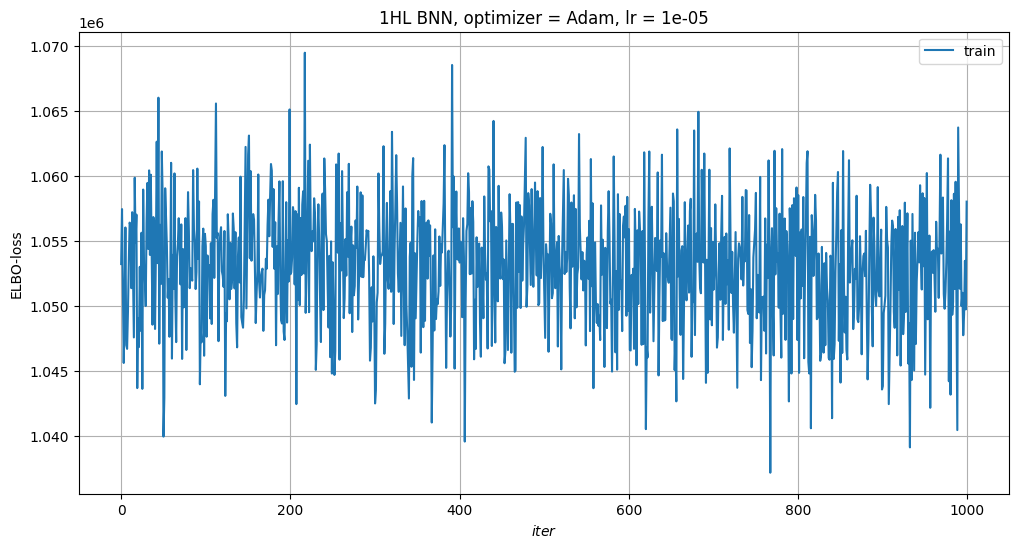

In [433]:
plot_loss(loss_arr,
          model = '1HL BNN',
          optimizer_name = 'Adam',
          lr = lr,
          loss_name = r'ELBO-loss',
          yscale = None,
          mode = 'train',
          figsize = (12, 6))

In [439]:

predictive = Predictive(model,num_samples=50)
preds = predictive(X_train[1:5])

mean_prediction = preds["obs"].mean(dim=0)
# Calculate upper and lower prediction intervals (e.g., 95% prediction intervals)
lower_quantile = np.percentile(preds["obs"], 5, axis=0)
upper_quantile = np.percentile(preds["obs"], 95, axis=0)

print(f"Mean Prediction: {mean_prediction}")
print(f"Lower Prediction Interval: {lower_quantile}")
print(f"Upper Prediction Interval: {upper_quantile}")



Mean Prediction: tensor([[ 5.0434],
        [15.8886],
        [ 9.5180],
        [ 5.8305]])
Lower Prediction Interval: [[-26.67495413]
 [-17.546663  ]
 [-20.86313381]
 [-12.90888271]]
Upper Prediction Interval: [[47.32211514]
 [60.37614517]
 [66.73185844]
 [43.13090954]]
